# Using a NN classifier to approximate a likelihood function

In this notebook, I will implement the approach described in the paper linked below to train a neural network (NN) approximating the likelihood function for normally distributed independent measurements. I will compare the result from the neural network to the exact, analytic likelihood function.

Primary reference: https://arxiv.org/pdf/1903.04057.pdf

In [1]:
import numpy as np
import math
import numba
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

# Step 1: Analytically evaluate a simple likelihood function

A likelihood function expresses agreement between a set of measurements, $\vec{x}$, and a set of hypothesis, or model, parameters, $\vec{\theta}$. Larger values of the likelihood function indicate better agreement between the model in question and the obtained measurements. Accordingly, the value of $\vec{\theta}$ for which the likelihood function is largest represents the most likely hypothesis given the observations, $\vec{x}$. Using a likelihood function to estimate model parameters and compare hypotheses is a form of statistical inference. In practice, we often work with the log of the likelihood function, called the log likelihood. Log likelihoods are generally more convenient than likelihoods because they combine with addition rather than multiplication. 

For example, consider a set of independent measurements drawn from a normal distribution with mean $\mu$ and standard deviation $\sigma$. In this case, the model parameters are $\mu$ and $\sigma$. The probability density function (pdf) governing each measurement $x$ is the following:

### $p(x|\mu, \sigma) = \frac{1}{\sqrt{2 \pi}\sigma} \exp\left[\frac{-(x-\mu)^2}{2\sigma^2}\right]$

From this pdf, one can derive the exact log likelihood function ($llh$) for a set of measurements, $\vec{x}$. The likelihood function $\mathcal{L}(\mu, \sigma | x)$ is equal to the pdf $p(x | \mu, \sigma)$ viewed as a function of the model parameters rather than as a function of $x$. The log likelihood function is the natural log of the likelihood function:

### $llh(\mu, \sigma | \vec{x}) \propto - \sum_i \left[\frac{\left(x_i-\mu\right)^2}{2\sigma^2} + \ln(\sigma)\right]$.

In the above equation, additive constants have been omitted because they are not relevant for our statistical inference. Note that the sum is over statistically independent measurements, $x_i$. More rigorous definitions and discussions of the above concepts are available in many statistics textbooks and online. Please let me know if you would like a specific recommendation for further reading.

Now consider a concrete distribution with parameters $(\mu, \sigma) = (3, 2)$. I will draw 1000 measurements from this distribution and visualize the exact two-dimensional log likelihood function.

In [3]:
@numba.njit
def eval_gaus(x, mu, sig):
    return 1/math.sqrt(2*math.pi)/sig*np.exp(-(x-mu)**2/(2*sig**2))

@numba.njit
def gaus_nll(mu, sig, x_i):
    return ((x_i - mu)**2/(2*sig**2) + math.log(sig)).sum()

In [4]:
n_measurements = 1000
test_mu = 3
test_sig = 2
x_i = test_sig*np.random.randn(n_measurements) + test_mu

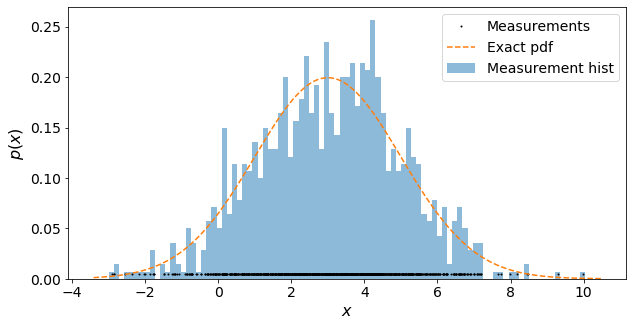

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

hist_bins = np.linspace(x_i.min() - 0.5, x_i.max() + 0.5, 100)
ax.hist(x_i, histtype='stepfilled', density='true',
        bins=hist_bins, alpha=0.5, 
        label='Measurement hist')

ax.plot(x_i, np.zeros_like(x_i) + 0.005, 'ko', label='Measurements', markersize=1)

eval_xs = np.linspace(x_i.min() - 0.5, x_i.max() + 0.5, 1000)
ax.plot(eval_xs, eval_gaus(eval_xs, test_mu, test_sig), 
         '--', label='Exact pdf')

ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.legend()

Now I will evaluate the log likelihood given these measurements. I will explore around the mean and standard deviation of the dataset. I will also show some likelihood contours because they are related to the statistical uncertainty of our parameter estimation.

In [6]:
@numba.njit
def nll_scan(x_i, means, stds):
    output = np.empty((len(stds), len(means)),
                      dtype=np.float64)
    
    for i, std in enumerate(stds):
        for j, mean in enumerate(means):
            output[i, j] = gaus_nll(mean, std, x_i)
            
    return output

In [7]:
def plot_nll_scan(x_i, nll_scan_func, ax, gridsize=200, title=None):
    meas_mean = x_i.mean()
    meas_std = x_i.std()

    err_mean = meas_std / math.sqrt(len(x_i))
    
    mean_range = np.linspace(meas_mean - 4.5*err_mean, meas_mean + 4.5*err_mean, gridsize)
    std_range = np.linspace(meas_std*0.85, meas_std*1.15, gridsize)

    nll_map = nll_scan_func(x_i, mean_range, std_range)

    ax.pcolormesh(mean_range, std_range, nll_map.min() - nll_map,
                   vmin=-10, vmax=0)

    ax.set_xlabel('$\mu$')

    ax.set_ylabel('$\sigma$')

    ax.plot([test_mu], [test_sig], 'k*', label='truth')

    best_fit_std_i, best_fit_mu_i = np.unravel_index(np.argmin(nll_map), nll_map.shape)

    ax.plot([mean_range[best_fit_mu_i]], [std_range[best_fit_std_i]], 'b*', label='best fit')

    ax.contour(mean_range, std_range, nll_map - nll_map.min(), [2.28/2, 4.61/2, 5.99/2], 
                colors=['blue', 'blue', 'blue'], linestyles=['solid', 'dashed', 'dotted'])
    
    if title is not None:
        ax.set_title(title)
    
    ax.legend(fontsize=16, loc='upper right')
    
    return nll_map, mean_range, std_range

CPU times: user 720 ms, sys: 8 ms, total: 728 ms
Wall time: 728 ms


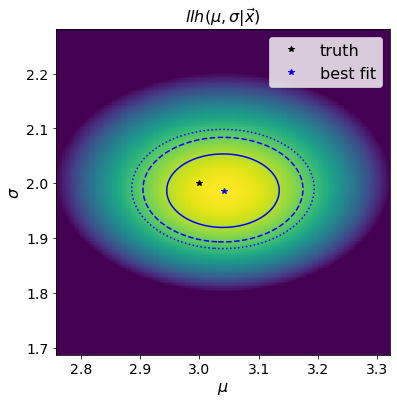

In [8]:
%%time
fig, ax = plt.subplots(figsize=(6, 6))
nll_map, mean_range, std_range = plot_nll_scan(x_i, nll_scan, ax, title=r'$llh(\mu, \sigma | \vec{x})$')


This two-dimensional map of the log likelihood shows us which sets of model parameters are favored by our measurement and which are disfavored. Bright regions are more likely than dark regions. The first contour represents one standard deviation of uncertainty. If we repeat this experiment many times, we expect the true model parameters to be inside of that one standard deviation contour about 68% of the time.   If we didn't already know the true parameters of our underlying distribution, following this likelihood scan we could be highly confident that they were within the outermost contour shown on the above plot. 

# Step 2: Train an artificial neural network to approximate the likelihood function

Now I will follow the algorithm described in the paper cited at the beginning of this notebook to train a neural network to approximate the likelihood function for this toy experiment.  

### Network input features: $x$, $\mu$, $\sigma$. 
### Network output: d. 

The output  of our network, $d$, is a classification score: the network is trying to determine whether ($x$, $\mu$, $\sigma$) were more likely sampled from the joint distribution $p(x, \mu, \sigma)$ or the combined marginal distributions $p(x)p(\mu, \sigma)$. Essentially, the network is trying to detect agreement between model parameters and measurements; this is qualitatively the same task accomplished by a likelihood function. 

With only three input features, I should be able to generate a large amount of training data.  

I will sample $\mu$ and $\sigma$ uniformly from the ranges [-10, 10] and [0.1, 20], respectively.

In [9]:
mu_min = -10
mu_max = 10
sig_min = 0.1
sig_max = 20
n_samples = 2000000
n_validation = int(n_samples/10)

In [10]:
def simulate(n):
    ''' returns xs, mus, sigs, mu_primes, sig_primes
    each of length n
    '''
    mus = np.random.uniform(mu_min, mu_max, n)
    sigs = np.random.uniform(sig_min, sig_max, n)
    xs = np.random.randn(n)*sigs + mus
    
    mu_primes = np.random.uniform(mu_min, mu_max, n)
    sig_primes = np.random.uniform(sig_min, sig_max, n)
    
    return xs, mus, sigs, mu_primes, sig_primes

### Build a basic feed forward NN with 4 hidden layers

In [11]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense

In [12]:
def build_basic_model():
    model = keras.models.Sequential()
    model.add(Dense(units=24, activation='elu',
                    input_shape=(3,)))
    model.add(Dense(units=24, activation='elu'))
    model.add(Dense(units=24, activation='elu'))
    model.add(Dense(units=12, activation='elu'))
    model.add(Dense(units=12, activation='elu'))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

In [13]:
model = build_basic_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 13        
Total params: 1,765
Trainable params: 1,765
Non-trainable params: 0
______________________________________________________

In [14]:
def prepare_training_tensor(n_samples):
    ''' returns training tensor and associated labels'''
    x, mu, sig, mu_p, sig_p = simulate(n_samples)
    tensor = np.empty((2*n_samples, 3), dtype=np.float32)
    
    class_1 = tensor[:n_samples, :]
    class_1[:, 0] = x
    class_1[:, 1] = mu
    class_1[:, 2] = sig
    
    class_0 = tensor[n_samples:, :]
    class_0[:, 0] = x
    class_0[:, 1] = mu_p
    class_0[:, 2] = sig_p 
    
    labels = np.array([[1]]*n_samples + [[0]]*n_samples)
    
    return tensor, labels

In [15]:
training_samples, training_labels = prepare_training_tensor(n_samples)
validation_samples, validation_labels = prepare_training_tensor(n_validation)

### Normalize the inputs 

In [16]:
feature_means = np.mean(training_samples, axis=0)
feature_stds = np.std(training_samples, axis=0)

In [17]:
training_samples[:] = (training_samples - feature_means)/feature_stds
validation_samples[:] = (validation_samples - feature_means)/feature_stds

### Define training parameters and then train the model

In [18]:
learning_rate = 0.005
patience = 10
batch_size = 10000

In [19]:
opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [20]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
history = model.fit(x=training_samples, y=training_labels,
                    batch_size=batch_size, epochs=200,
                    callbacks=callbacks, 
                    validation_data=(validation_samples, 
                                     validation_labels),
                    shuffle=True)

Epoch 1/200
400/400 [==============================] - 1s 4ms/step - loss: 0.5868 - accuracy: 0.6621 - val_loss: 0.5722 - val_accuracy: 0.6736
Epoch 2/200
400/400 [==============================] - 1s 3ms/step - loss: 0.5714 - accuracy: 0.6735 - val_loss: 0.5721 - val_accuracy: 0.6739
Epoch 3/200
400/400 [==============================] - 2s 4ms/step - loss: 0.5707 - accuracy: 0.6739 - val_loss: 0.5711 - val_accuracy: 0.6744
Epoch 4/200
400/400 [==============================] - 2s 4ms/step - loss: 0.5706 - accuracy: 0.6739 - val_loss: 0.5717 - val_accuracy: 0.6731
Epoch 5/200
400/400 [==============================] - 1s 3ms/step - loss: 0.5705 - accuracy: 0.6739 - val_loss: 0.5725 - val_accuracy: 0.6721
Epoch 6/200
400/400 [==============================] - 1s 4ms/step - loss: 0.5705 - accuracy: 0.6741 - val_loss: 0.5711 - val_accuracy: 0.6737
Epoch 7/200
400/400 [==============================] - 1s 3ms/step - loss: 0.5704 - accuracy: 0.6740 - val_loss: 0.5706 - val_accuracy: 0.6748

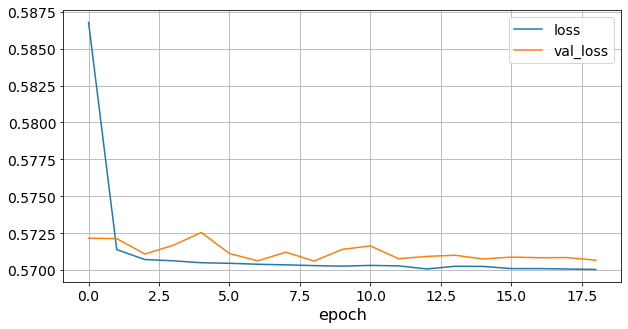

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
for quantity, vals in history.history.items():
    if quantity.endswith('loss'):
        ax.plot(vals, label=quantity)
plt.legend()
ax.set_xlabel('epoch')
plt.grid()

Now that we've trained the network, let's use it to conduct the same scan that we did with the exact, analytic likelihood function. 

In [22]:
def NN_nll_batch(mus, sigs, x_i,
                 model=model, mean=feature_means, std=feature_stds,
                 max_batch_size=100000):
    ''' returns the neural net NLL 
        for each hypothesized mu, sig in mus and sigs
        outputs a 2d array of the NLL values.
        
        evaluation for mu_i, sig_j is located at output_array[j, i]
    '''    
    x_i = np.copy(np.atleast_1d(x_i))
    mus = np.copy(np.atleast_1d(mus))
    sigs = np.copy(np.atleast_1d(sigs))
    
    # apply normalization before building the tensor
    for i, arr in enumerate([x_i, mus, sigs]):
        arr[:] = (arr - feature_means[i])/feature_stds[i]
    
    tensor = np.empty((len(x_i)*len(mus)*len(sigs), 3), dtype=np.float32) 
    tensor[:, 0] = np.tile(x_i, len(mus)*len(sigs))
    tensor[:, 1] = np.tile(np.repeat(mus, len(x_i)), len(sigs))
    tensor[:, 2] = np.repeat(sigs, len(x_i)*len(mus))
        
    batch_size = min(len(tensor), max_batch_size)
    
    ds = model.predict(tensor, batch_size=batch_size)[:, -1]
    
    ds = ds.reshape((len(sigs), len(mus), len(x_i)))
    
    return (-np.log(ds/(1-ds))).sum(axis=-1)
    
    
def NN_nll_scan(x_i, means, stds):
    return NN_nll_batch(means, stds, x_i)

### Comparison of the log likelihood map from the exact likelihood fucntion to the map from the neural network

CPU times: user 3.03 s, sys: 996 ms, total: 4.03 s
Wall time: 2.69 s


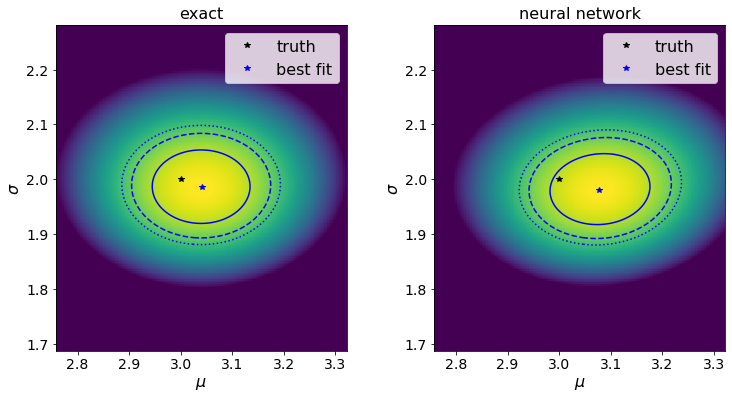

In [23]:
%%time
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
plt.subplots_adjust(wspace=0.3)
axiter = ax.flat
ax = next(axiter)
nll_map, mean_range, sig_range = plot_nll_scan(x_i, nll_scan, ax, title='exact')
ax = next(axiter)
NN_nll_map, NN_mean_range, NN_sig_range = plot_nll_scan(x_i, NN_nll_scan, ax, title='neural network')

The neural network produced a likelihood map very similar to the one produced by the exact equation. While in this example we had access to the exact likelihood function, in many real-word applications we do not. On the other hand, we often have access to a simulation that allows us to train a neural network in the same way that we just trained this one. As such a network provides an approximation of the likelihood function, it can be used to conduct statistical inference in the same way that a likelihood function would be. We are currently exploring using this technique to conduct event reconstruction in the IceCube and WATCHMAN-AIT experiments.